# 時系列分析：SARIMAモデル

### 時系列データの読み込み

データの取得元：<a href='https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv'>https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv</a>

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
#from pandas import datetime
import itertools
%matplotlib inline

# 描画サイズ規定値設定
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

# 処理時に警告を表示させない
import warnings
warnings.filterwarnings('ignore')

# 時系列データの読み込み（その１）
df = pd.read_csv('AirPassengers.csv',
                 index_col="Month",
                 parse_dates=True,  # parserを別途定義して指定も可
                 dtype='float')
df.head()

,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [56]:
# 時系列データの読み込み（その２）
df = pd.read_csv('AirPassengers.csv')
index = pd.date_range('1949-01', '1960-12', freq='MS')
df.index=index
del df['Month']
df = df.astype('float')
df.head()

,#Passengers
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


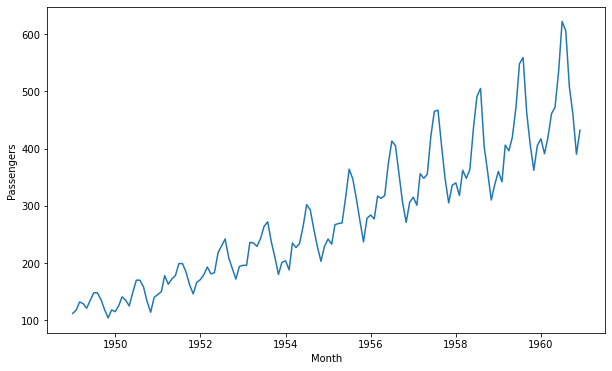

In [58]:
# 時系列データをプロット
#plt.figure(figsize=(10, 6))
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.plot(df);

### トレンド、季節変動、残差の確認

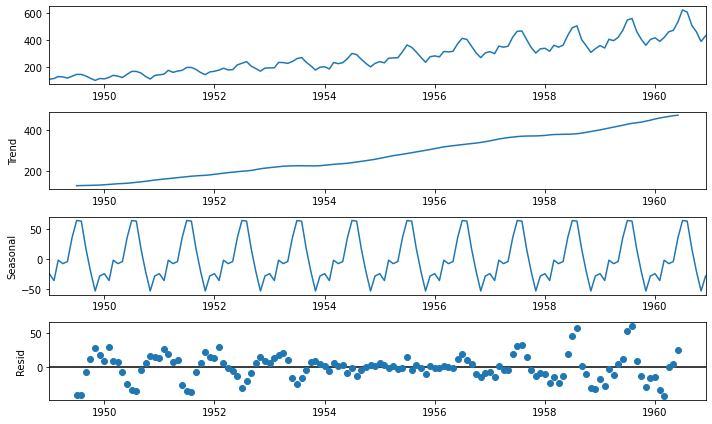

In [59]:
# トレンド、季節変動、残差に分解
res = sm.tsa.seasonal_decompose(df, freq=12)
fig = res.plot()
plt.show()

#　個々に描画する場合
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(4, 1, 1)
# ax.set_ylabel('Observed')
# ax.plot(res.observed)
# ax = fig.add_subplot(4, 1, 2)
# ax.set_ylabel('Trend')
# ax.plot(res.trend)
# ax = fig.add_subplot(4, 1, 3)
# ax.set_ylabel('Seasonal')
# ax.plot(res.seasonal)
# ax = fig.add_subplot(4, 1, 4)
# ax.set_ylabel('Residual')
# ax.plot(res.resid)
# plt.show()

周期が１２ヶ月であることが分かる。

### 自己相関係数の確認

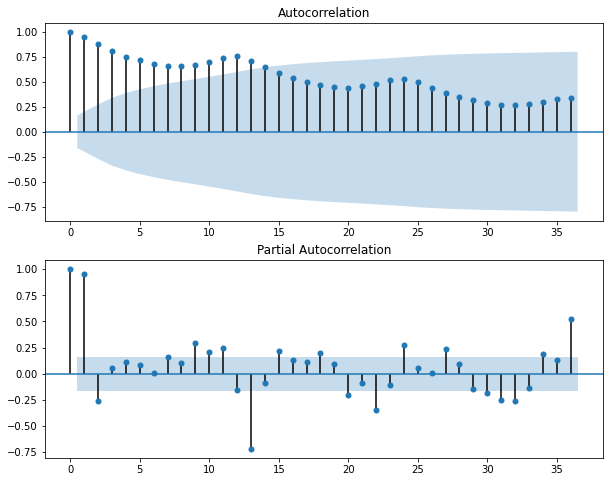

In [66]:
# 自己相関係数と偏自己相関係数をグラフ化して周期を確認
fig=plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(2, 1, 1) 
fig = sm.graphics.tsa.plot_acf(res.observed, lags=36, ax=ax1)  # 自己相関係数のコレログラム
#fig = sm.graphics.tsa.plot_acf(df, lags=36, ax=ax1)  # 自己相関係数のコレログラム
ax2 = fig.add_subplot(2, 1, 2)
fig = sm.graphics.tsa.plot_pacf(res.observed, lags=36, ax=ax2)  # 偏自己相関係数のコレログラム
plt.show()

自己相関係数から、12ヶ月間隔で相関が高いことが分かる。<br>
偏自己相関係数からは、1ヶ月前のデータとの相関が高いことが分かる。

色の濃い範囲は、帰無仮説「相関が無い」に対する「95%信頼区間」であり、
- この範囲内であれば「相関は誤差の範囲」
- この範囲を超える場合は「統計的に有意な相関がある」と言える

**注釈：statsmodelsのバージョンによる偏自己相関係数の違い**<br>
statsmodelsのバージョンによって表示（計算結果）が異なる。
- version 0.8.0: 
    - 正常と思われる結果を得た
- version 0.10.0, および0.11.1:
    - 36ヶ月以降の値が異なり、39ヶ月目には係数値"30"を超える値が算出されている

statsmodels version 0.11.1で40ヶ月まで表示すると次の通り。

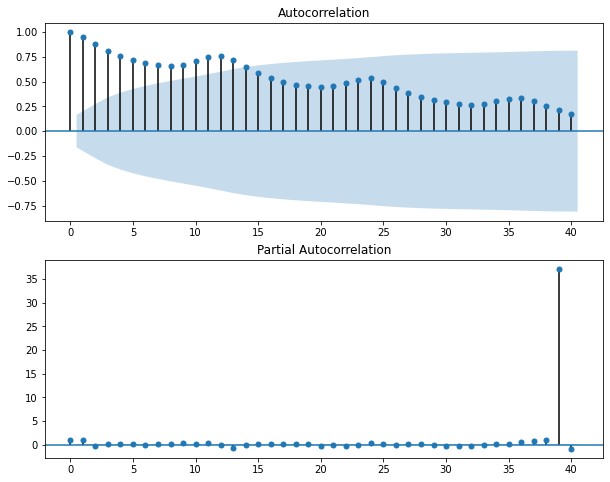

In [219]:
# 自己相関係数と偏自己相関係数をグラフ化して周期を確認
fig=plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(2, 1, 1) 
fig = sm.graphics.tsa.plot_acf(res.observed, lags=40, ax=ax1)  # 自己相関係数のコレログラム
#fig = sm.graphics.tsa.plot_acf(df, lags=40, ax=ax1)  # 自己相関係数のコレログラム
ax2 = fig.add_subplot(2, 1, 2)
fig = sm.graphics.tsa.plot_pacf(res.observed, lags=40, ax=ax2)  # 偏自己相関係数のコレログラム
plt.show()

### SARIMAモデル構築：パラメータの決定

In [17]:
%%time

# SARIMAモデルの最適パラメータを取得する
# 総当たりで次のパラメータの最適な組合せを求める
# 　　　　評価指標：BIC（ベイズ情報量規準）
#     p:   自己相関度（ARモデルの次数）
#     d:   差分（階差）
#     q:   移動平均（MAモデルの次数）
#     sp: 季節性自己相関度
#     sd: 季節性残差
#     sq: 季節性移動平均
#     s:   周期（季節性：事前に指定する値）

# p, q, d各々の候補値をリストで用意する
p = [0, 1, 2, 3]
d = [0, 1]
q = [0, 1, 2, 3]
sp = [0, 1, 2]
sd = [0, 1, 2]
sq = [0, 1, 2]
s = 12

# 各リストから要素を一つづつ取り出す組合せ全て（直積）を取得する 
# ARIMAモデルパラメータ：[(p, d, q), ...]
orders = list(itertools.product(p, d, q))
# 季節性パラメータ: [(sp, sd, sq, s), ...]
seasonal_orders = [(sx[0], sx[1], sx[2], s) for sx in list(itertools.product(sp, sd, sq))]

# (p, d, q), (sp, sd, sq)を総当たりで検証し、BIC値が最小となる組合せを最適と判定する
bic_min = float('inf')
order_opt = ()
s_order_opt = ()
for order in orders:
    for s_order in seasonal_orders:
        # SARIMAモデル作成
        # エラー回避のために次のパラメータに'False'を指定する
        # - enforce_stationarity: Trueの場合、定常過程に自己回帰モデルを適用する
        # - enforce_invertibility: Trueの場合、MAモデルの反転可能条件を維持する
        sarima = sm.tsa.statespace.SARIMAX(df,
                                          order=order,
                                          seasonal_order=s_order,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False).fit()
        # AIC値の最小判定
        if sarima.bic < bic_min:
            bic_min = sarima.bic
            order_opt = order
            seasonal_order_opt = s_order


# SARIMAモデルの最適パラメータを表示
print("--- 最適パラメータ (BIC)---")
print("order(p, d, q): ", order_opt)
print("seasonal(sp, sd, sq, s): ", seasonal_order_opt)
print("BIC: ", bic_min)

--- 最適パラメータ (BIC)---
order(p, d, q):  (2, 1, 3)
seasonal(sp, sd, sq, s):  (0, 2, 2, 12)
BIC:  726.1044213423528
CPU times: user 57min 27s, sys: 26.5 s, total: 57min 54s
Wall time: 16min 57s


In [18]:
%%time

# SARIMAモデルの最適パラメータを取得する
# 総当たりで次のパラメータの最適な組合せを求める
#     評価指標：AIC（赤池情報量規準）
#     p:   自己相関度（ARモデルの次数）
#     d:   差分（階差）
#     q:   移動平均（MAモデルの次数）
#     sp: 季節性自己相関度
#     sd: 季節性残差
#     sq: 季節性移動平均
#     s:   周期（季節性：事前に指定する値）

# p, q, d各々の候補値をリストで用意する
p = [0, 1, 2, 3]
d = [0, 1]
q = [0, 1, 2, 3]
sp = [0, 1, 2]
sd = [0, 1, 2]
sq = [0, 1, 2]
s = 12

# 各リストから要素を一つづつ取り出す組合せ全て（直積）を取得する 
# ARIMAモデルパラメータ：[(p, d, q), ...]
orders = list(itertools.product(p, d, q))
# 季節性パラメータ: [(sp, sd, sq, s), ...]
seasonal_orders = [(sx[0], sx[1], sx[2], s) for sx in list(itertools.product(sp, sd, sq))]

# (p, d, q), (sp, sd, sq)を総当たりで検証し、AIC値が最小となる組合せを最適と判定する
aic_min = float('inf')
order_opt = ()
s_order_opt = ()
for order in orders:
    for s_order in seasonal_orders:
        # SARIMAモデル作成
        # エラー回避のために次のパラメータに'False'を指定する
        # - enforce_stationarity: Trueの場合は、定常過程に自己回帰モデルを適用する
        # - enforce_invertibility: Trueの場合は、MAモデルの反転可能条件を維持する
        sarima = sm.tsa.statespace.SARIMAX(df,
                                          order=order,
                                          seasonal_order=s_order,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False).fit()
        # AIC値の最小判定
        if sarima.aic < aic_min:
            aic_min = sarima.aic
            order_opt = order
            seasonal_order_opt = s_order


# SARIMAモデルの最適パラメータを表示
print("--- 最適パラメータ(AIC) ---")
print("order(p, d, q): ", order_opt)
print("seasonal(sp, sd, sq, s): ", seasonal_order_opt)
print("AIC: ", aic_min)

--- 最適パラメータ(AIC) ---
order(p, d, q):  (2, 1, 3)
seasonal(sp, sd, sq, s):  (0, 2, 2, 12)
AIC:  706.017545290218
CPU times: user 54min 7s, sys: 22.4 s, total: 54min 29s
Wall time: 15min 45s


AICとBICで、最適パラメータの判定結果は同じ。

### SARIMAモデル構築：モデルの検証

In [19]:
# 最適パラメータによるSARIMAモデル生成
sarima = sm.tsa.statespace.SARIMAX(df,
                                   order=(2, 1, 3),
                                   seasonal_order=(0, 2, 2, 12),
                                   enforce_stationarity=False,
                                   enforce_invertibility=False).fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                             #Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 3)x(0, 2, [1, 2], 12)   Log Likelihood                -345.009
Date:                                 Sun, 11 Oct 2020   AIC                            706.018
Time:                                         12:18:53   BIC                            726.104
Sample:                                     01-01-1949   HQIC                           714.121
                                          - 12-01-1960                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0386      0.080    -12.964      0.000      -1.196      -0.882
ar.L2         -0.9345      0.063    -14.952      0.000      -1.057      -0.812
ma.L1          0.6371      0.276      2.310      0.021       0.097       1.178
ma.L2          0.7493      0.439      1.706      0.088      -0.111       1.610
ma.L3         -0.2666      0.192     -1.390      0.165      -0.643       0.109
ma.S.L12      -1.6974      2.314     -0.733      0.463      -6.234       2.839
ma.S.L24       0.6609      1.687      0.392      0.695      -2.645       3.967
sigma2        75.7805    168.043      0.451      0.652    -253.578     405.139
===================================================================================
Ljung-Box (Q):                       27.11   Jarque-Bera (JB):                 0.92
Prob(Q):                              0.94   Prob(JB):                         0.63
Heteroskedasticity (H):               2.06   Skew:                             0.24
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

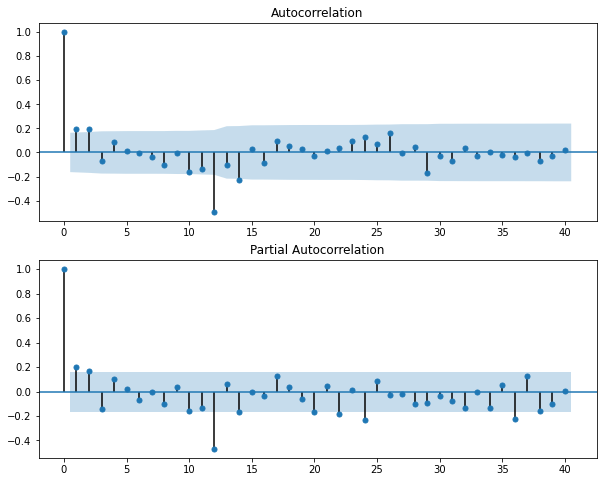

In [61]:
# モデルの妥当性検証：残差を確認
fig=plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(2, 1, 1) 
fig = sm.graphics.tsa.plot_acf(sarima.resid, lags=40, ax=ax1)  # 自己相関係数のコレログラム
ax2 = fig.add_subplot(2, 1, 2)
fig = sm.graphics.tsa.plot_pacf(sarima.resid, lags=40, ax=ax2)  # 偏自己相関係数のコレログラム
plt.show()

概ね残差は小さい。（12ヶ月の負の相関は何だろうか？）<br>
今回はAICによる判定によって最適なパラメータを特定したが、これを鵜呑みにせず、ハマり具合を検証しながら解析を行うこと。

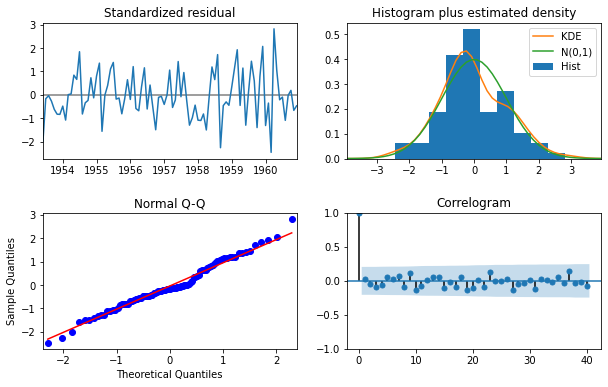

In [64]:
# モデルの妥当性検証：診断(組込関数)
sarima.plot_diagnostics(lags=40)
plt.subplots_adjust(hspace=0.4)
plt.show();  # これを実行しないとなぜか二重表示されてしまう(インライン表示指定を無くしても変わらず)

（左上）：標準化した残差<br>
（右上）：残差のヒストグラム、正規分布、KDE分布<br>
（左下）：残差の正規Q-Qプロット<br>
（右下）：残差の自己相関係数コレログラム<br>

### 予測

時系列データを学習データとテストデータに分割して、SARIMAモデルに学習させる。<br>
SARIMAモデルのパラメータは、上記で最適化した値を使う。<br>
（本来は学習データを使って、再度パラメータの最適化をしてみるのが適当であろう）

In [114]:
# 学習データとテストデータに分割
data_train = df['1949-01':'1959-12']
data_test = df['1960-01':'1960-12']

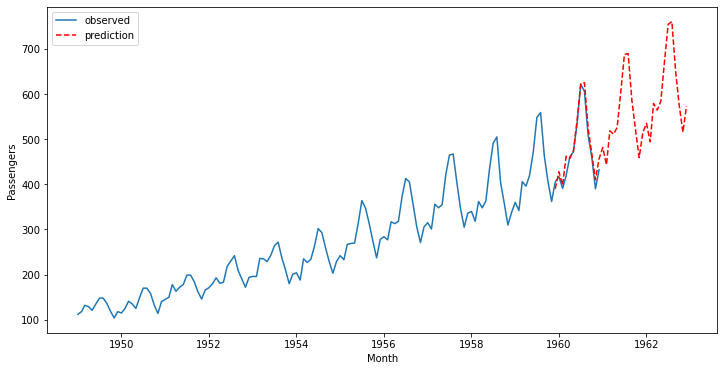

In [115]:
# 最適パラメータによるSARIMAモデル生成
sarima = sm.tsa.statespace.SARIMAX(data_train,
                                   order=(2, 1, 3),
                                   seasonal_order=(0, 2, 2, 12),
                                   enforce_stationarity=False,
                                   enforce_invertibility=False).fit()

# 予測（その１）
pred = sarima.predict("1959-12", "1962-12")  # 予測開始時点は、学習データに存在する時点を指定

# 原系列データと予測データをグラフに表示する
plt.figure(figsize=(12, 6))
plt.plot(df, label='observed')
plt.plot(pred, label='prediction', c='r', ls='--');
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.legend();

目視では、概ね良い予測結果が得られている。
- 1959-01から1960-12の期間は、実測値と比較でき、よく当てはまっているように見える
- 1961-01から1962-12の期間も、トレンド、周期を含めてそれらしい予測に見える

### 予測の信頼区間と予測精度

In [209]:
# 予測（その２）
pred = sarima.get_prediction(start=pd.to_datetime("1959-12"),
                              end = pd.to_datetime("1961-12"),
                              dynamic=True)  #  現時点の値を次時点の予測に使用する
 
# 予測の期待値
pred_mean = pred.predicted_mean
#　95％信頼区間
pred_ci = pred.conf_int(alpha = 0.05)

# 信頼区間の上限と下限を確認
pred_ci.head()

,lower #Passengers,upper #Passengers
1959-12-01,372.384820,407.737919
1960-01-01,393.744376,438.588082
1960-02-01,360.310720,413.009360
1960-03-01,420.247969,480.126968
1960-04-01,412.919375,478.701316


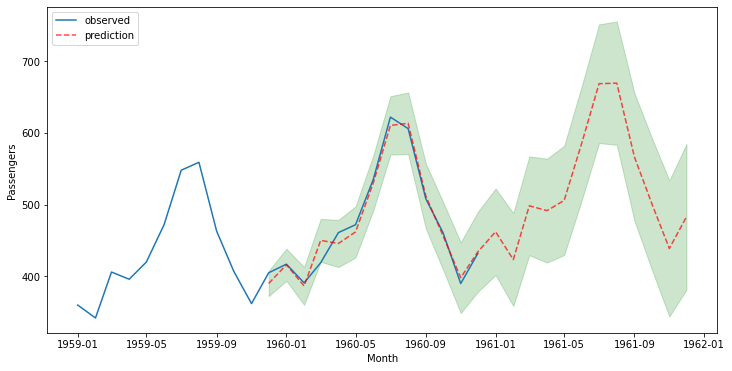

In [207]:
# 予測の期待値を描画
plt.figure(figsize=(12, 6))
plt.plot(df['1959-01':], label='observed')
plt.plot(pred_mean, label='prediction', c='r', ls='--', alpha=0.7)
 
# 95%信頼区間を描画
plt.fill_between(pred_ci.index, 
                 pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], 
                 color='g', alpha=0.2)
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.legend(loc='upper left');

In [208]:
# 予測精度：RMSEで評価する
y = data_test['#Passengers']
y_pred = pred_mean[1:-12,]  # 実測値がある区間をスライス(1960-01〜1960-12)
rmse = np.sqrt(((y_pred - y)**2).mean())
print("RMSE: ", rmse)

RMSE:  11.682383380387027


乗客数400〜600人程度のオーダに対して、ブレ幅10人程度の精度で予測できている。

### さらなる試みに向けて：<br>
- SARIMAモデル適用の妥当性を事前に検証する手段として
    - 原系列からトレンドを除去したら定常過程になるか検証：階差系列を解析し、定常過程と見做せるか、もしくは季節性とみられるスパイクが残っているのみであれば妥当
    - 原系列が単位根過程を持つか（１次の階差系列が定常過程か）確認するために、ADF検定を用いる